In [493]:
import cv2
from IPython.display import display, HTML
import glob
from random import randrange
try:
    import Image
except ImportError:
    from PIL import Image
import numpy as np
from pprint import pprint as pp

In [342]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [343]:
# https://stackoverflow.com/questions/14063070/overlay-a-smaller-image-on-a-larger-image-python-opencv
def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    
#     rgba = cv2.cvtColor(img_overlay, cv2.COLOR_BGR2BGRA)
#     alpha_mask = rgba[:, :, 3] / 255.0 
#     alpha_mask = alpha_mask - alpha
#     img_overlay = rgba[:, :, :3]
    
#     img = img[:, :, :3].copy()
    
    # Pass only copies!!!!!!!!!!!!!!!!!!
    img = img.copy()
    img_overlay = img_overlay.copy()
    alpha_mask = alpha_mask.copy()
    
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        print("XD")
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha
    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop
    return img

In [627]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __str__(self) -> str:
        return str(self.__dict__)
    
    def __format__(self, format_spec: str) -> str:
        return str(self.__dict__)
    
    def __repr__(self) -> str:
        return str(self.__dict__)

    
# https://leetcode.com/problems/rectangle-overlap/solution/
def isRectangleOverlap(rec1, rec2):
    def intersect(p_left, p_right, q_left, q_right):
        return min(p_right, q_right) > max(p_left, q_left)
    return (intersect(rec1[0], rec1[2], rec2[0], rec2[2]) and # width > 0
            intersect(rec1[1], rec1[3], rec2[1], rec2[3]))    # height > 0
 
    return True

[[{'x': 1, 'y': 2}]]


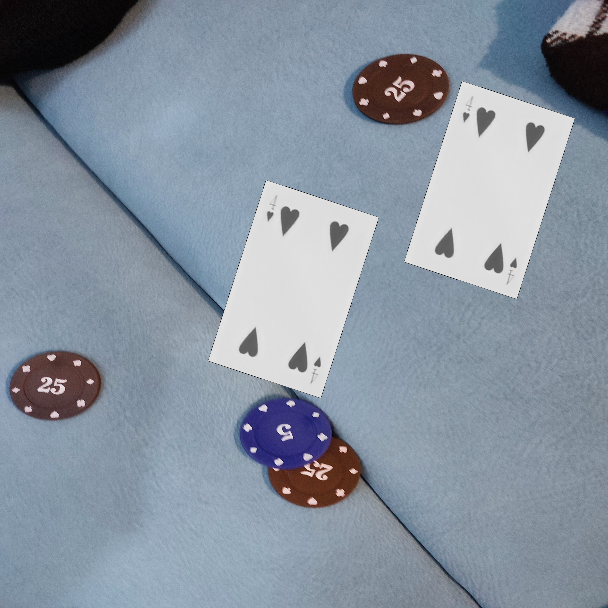

In [714]:
class Transformator:
    def __init__(self, x, y) -> None:
        super().__init__()
        self.img_size_x = x
        self.img_size_y = y

    def transform(self, card, background):
        augumented_card, augumented_KP = self.augument_card(card)
        
        scaleBg = iaa.Resize({"height": 608, "width": 608})
        background_with_cards = scaleBg.augment_image(img2)
        #print(background_with_cards.shape) #(608, 608, 3)
        background_shape = background_with_cards.shape
        card_shape = augumented_card.shape
        
        taken_regions = []
        
        for _ in range(0, 5):
            should_continue = False
            x = randrange(0, background_shape[1]-card_shape[1])
            y = randrange(0, background_shape[0]-card_shape[0])
            wanna_be_region = [Point(x,y), Point(x+card_shape[1], y+card_shape[0])]
            wanna_be_region =  [x, y, x+card_shape[1], y+card_shape[0]]
#             print("Taken:", taken_regions)
#             print("Candidat:", wanna_be_region)

            for taken_region in taken_regions:                
                if isRectangleOverlap(wanna_be_region, taken_region):
#                     print("Overlapping")
                    should_continue = True
#                 pass
            if should_continue:
                continue
    
            background_with_cards, bg_kp, BG_kp = self.copy_card_onto_background(augumented_card, background_with_cards, x, y, 
                                                               augumented_KP)
            #x1,y1, x2,y2
            taken_regions.append([bg_kp.keypoints[0].x, bg_kp.keypoints[0].y, bg_kp.keypoints[1].x, bg_kp.keypoints[1].y])
        display(Image.fromarray(background_with_cards))
#             pp(taken_regions)
        
        
    def augument_card(self, card, keypoints =[]):
        cardKP = ia.KeypointsOnImage([
            ia.Keypoint(x=10,y=10),
            ia.Keypoint(x=38, y=70),
            ia.Keypoint(x=10, y=70),
            ia.Keypoint(x=38,y=10),   
            ], shape=img1.shape)

        seq = iaa.Sequential([
            iaa.Affine(
                scale=(0.6, 0.65),
                shear=(-16, 16),
                rotate=(-45, 45),
                mode="constant",
                cval=0,
                #              mode=ia.ALL, cval=(0, 0)
                fit_output=True

            ),  # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
            #     iaa.Rotate((-45, 45),), # fit_output=True

        ])

        augumented_card, augumented_KP = seq(image=card, keypoints=cardKP)
        img_to_display = augumented_KP.draw_on_image(augumented_card, size=5, color=[0, 0, 255])

#         display(Image.fromarray(img_to_display))
        return augumented_card, augumented_KP
    
    def copy_card_onto_background(self, card, background, x, y, augumented_KP):
        img1_aug = card

        alpha = np.sum(img1_aug, axis=-1) > 0
        alpha = np.uint8(alpha * 255)
        rgba = np.dstack((img1_aug, alpha))


        alpha_mask = rgba[:, :, 3] / 255.0
        img_result = background[:, :, :3].copy()
        img_overlay = rgba[:, :, :3]

        aug_background = overlay_image_alpha(img_result, img_overlay, x=x, y=y, alpha_mask=alpha_mask)

        # for kp in bbs_aug.keypoints:
        #     print(kp.x)
        new_keypoints = ia.KeypointsOnImage([ia.Keypoint(x=kp.x+x,y=kp.y+y) for kp in augumented_KP.keypoints], shape=aug_background.shape)
        card_bounding_keypoints =  ia.KeypointsOnImage([ia.Keypoint(x=x, y=y),
#                                                         ia.Keypoint(x=x+img_overlay.shape[1], y=y),
#                                                         ia.Keypoint(x=x, y=y+img_overlay.shape[0]),
                                                        ia.Keypoint(x=x+img_overlay.shape[1], y=y+img_overlay.shape[0])
                                                       ], shape=aug_background.shape)

        img_to_display = new_keypoints.draw_on_image(aug_background, size=5, color=[0, 0, 255])
        img_to_display = card_bounding_keypoints.draw_on_image(img_to_display, size=5, color=[0,0,255])
#         display(Image.fromarray(img_to_display))
#         print(card_bounding_keypoints)
        return aug_background, card_bounding_keypoints, new_keypoints

transformator = Transformator(608, 608)
transformator.transform(img1, img2)
pass

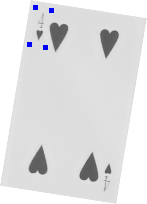

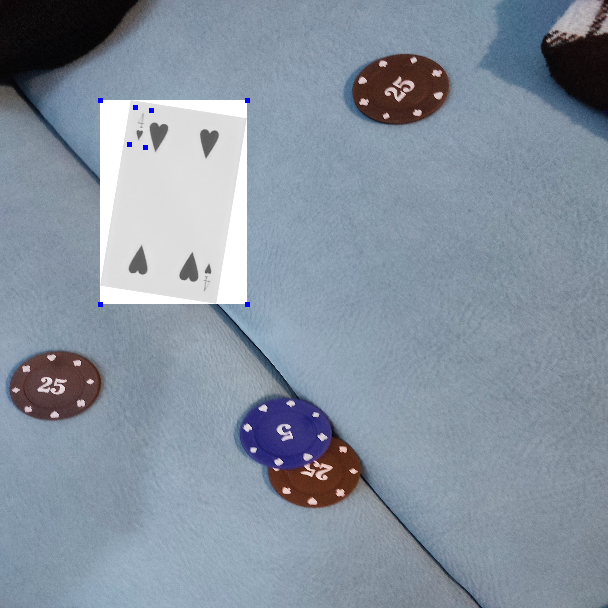

In [345]:
img1 = glob.glob('./circles/*.png')[0]
img2 = glob.glob('./circles/*.png')[1]

img1 = cv2.imread(img1, cv2.IMREAD_COLOR)
# img1 = np.array(Image.open(img1))
# img1 = cv2.resize(img1, None, fx=0.25, fy=0.25)

img2 = cv2.imread(img2, cv2.IMREAD_COLOR)
# img2 = cv2.resize(img2, None, fx=0.25, fy=0.25)

In [346]:
bbs = BoundingBoxesOnImage([
    BoundingBox(x1=25, y1=25, x2=50, y2=50),
    BoundingBox(x1=75, y1=75, x2=100, y2=100)
], shape=img1.shape)

In [347]:
cardKP = ia.KeypointsOnImage([
    ia.Keypoint(x=10,y=10),
    ia.Keypoint(x=38, y=70),
    ia.Keypoint(x=10, y=70),
    ia.Keypoint(x=38,y=10),   
    ], shape=img1.shape)

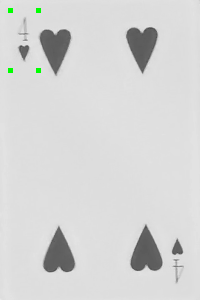

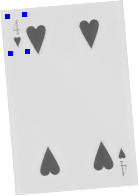

In [377]:
seq = iaa.Sequential([
        iaa.Affine(
        scale=(0.6, 0.65),
        shear=(-16, 16),
        rotate=(-45, 45),
        mode="constant", 
        cval=255,
#              mode=ia.ALL, cval=(0, 0)
        fit_output = True

    ), # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
#     iaa.Rotate((-45, 45),), # fit_output=True

])

img1_f = cardKP.draw_on_image(img1, size=5)
display(Image.fromarray(img1_f))

img1_aug, bbs_aug = seq(image=img1, keypoints=cardKP)

img1_f = bbs_aug.draw_on_image(img1_aug, size=5, color=[0, 0, 255])
display(Image.fromarray(img1_f))

error: OpenCV(4.5.4) /tmp/pip-req-build-24v3eisa/opencv/modules/core/src/count_non_zero.dispatch.cpp:160: error: (-215:Assertion failed) src.channels() == 1 && src.dims == 2 in function 'findNonZero'


(196, 139, 3)


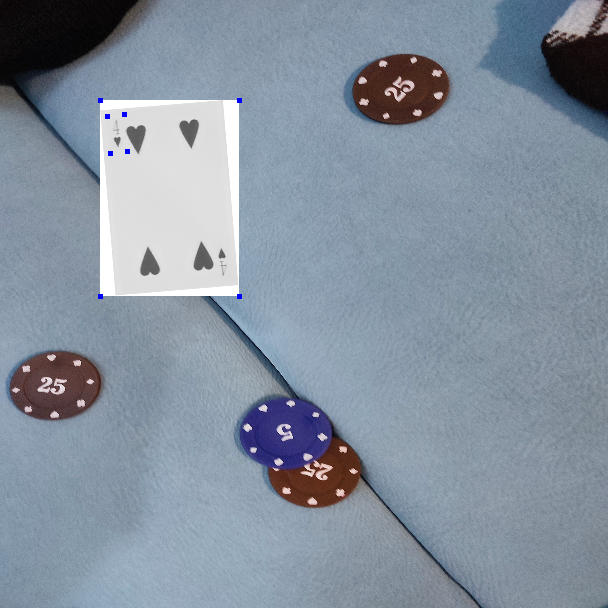

In [388]:
scaleBg = iaa.Resize({"height": 608, "width": 608})
img2_f = scaleBg.augment_image(img2)


# rgba = cv2.cvtColor(img1_aug, cv2.COLOR_BGR2BGRA)
# # print(rgba)
# # rgba[np.where(rgba==[0,0,0,255])] = [0,0,0,0]

# print(rgba==[0,0,0,255])
alpha = np.sum(img1_aug, axis=-1) > 0
alpha = np.uint8(alpha * 255)
rgba = np.dstack((img1_aug, alpha))


alpha_mask = rgba[:, :, 3] / 255.0
img_result = img2_f[:, :, :3].copy()
img_overlay = rgba[:, :, :3]
x = 100
y = 100

xd = overlay_image_alpha(img_result, img_overlay, x=x, y=y, alpha_mask=alpha_mask)
print(img_overlay.shape)
# for kp in bbs_aug.keypoints:
#     print(kp.x)
new_keypoints = ia.KeypointsOnImage([ia.Keypoint(x=kp.x+x,y=kp.y+y) for kp in bbs_aug.keypoints], shape=xd.shape)
card_bounding_keypoints =  ia.KeypointsOnImage([ia.Keypoint(x=x, y=y),
                                                ia.Keypoint(x=x+img_overlay.shape[1], y=y),
                                                ia.Keypoint(x=x, y=y+img_overlay.shape[0]),
                                                ia.Keypoint(x=x+img_overlay.shape[1], y=y+img_overlay.shape[0])
                                               ], shape=xd.shape)

xd = new_keypoints.draw_on_image(xd, size=5, color=[0, 0, 255])
xd = card_bounding_keypoints.draw_on_image(xd, size=5, color=[0,0,255])
display(Image.fromarray(xd))